# Sistema recomendador

La idea es utilizar el dataset que se ha generado en el notebook Exploración-dataset-imdb y generar un modelo que combinará un sistema recomendador basado en contenido con el algorimo KMeans.

In [518]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from joblib import dump, load

%matplotlib inline

In [373]:
!ls ./data

IMDb movies.csv        movies_clean.csv       movies_with_labels.csv


In [535]:
# Cargamos el dataset movies_clean.csv
df = pd.read_csv('./data/movies_clean.csv')

In [536]:
df.head()

,id,title,genre,country,epoch,duration,known,description
0,tt0002130,L'Inferno,"Adventure, Drama, Fantasy",Italy,classic,short,unknown,Loosely adapted from Dante's Divine Comedy and...
1,tt0003740,Cabiria,"Adventure, Drama, History",Italy,classic,long,unknown,Cabiria is a Roman child when her home is dest...
2,tt0004707,Tillie's Punctured Romance,Comedy,USA,classic,short,unknown,A con man from the city dupes a wealthy countr...
3,tt0004972,The Birth of a Nation,"Drama, History, War",USA,classic,long,known,The Stoneman family finds its friendship with ...
4,tt0005078,The Cheat,"Drama, Romance",USA,classic,short,unknown,"A venal, spoiled stockbroker's wife impulsivel..."


In [537]:
df.shape

(19986, 8)

La idea es combinar la columna genres y tag para poder recomendar películas a los usuarios a partir del contenido de las palabras. Para ello utilizamos TfidVectorzer de la librería sklearn, nos permite crear a partir de texto una matriz TF-IDF. Esta matriz que nos indica lo relevante que es cada palabra en el documento que aparece, dentro de la colección de documentos. Más información [aquí](https://es.wikipedia.org/wiki/Tf-idf)


In [538]:
# Lo primero que haremos será combinar las columnas genres y tags en una única columna llamada documents

def join_data(d):
    
    return f'''{str(d["genre"]).replace(",", " ").lower()}. {d["epoch"]}. {d['known']}'''



df['documents'] = df.apply(join_data, axis=1)

In [539]:
df.head()

,id,title,genre,country,epoch,duration,known,description,documents
0,tt0002130,L'Inferno,"Adventure, Drama, Fantasy",Italy,classic,short,unknown,Loosely adapted from Dante's Divine Comedy and...,adventure drama fantasy. classic. unknown
1,tt0003740,Cabiria,"Adventure, Drama, History",Italy,classic,long,unknown,Cabiria is a Roman child when her home is dest...,adventure drama history. classic. unknown
2,tt0004707,Tillie's Punctured Romance,Comedy,USA,classic,short,unknown,A con man from the city dupes a wealthy countr...,comedy. classic. unknown
3,tt0004972,The Birth of a Nation,"Drama, History, War",USA,classic,long,known,The Stoneman family finds its friendship with ...,drama history war. classic. known
4,tt0005078,The Cheat,"Drama, Romance",USA,classic,short,unknown,"A venal, spoiled stockbroker's wife impulsivel...",drama romance. classic. unknown


In [540]:
# Instanciamos el proceso indicando que usamos el idioma inglés
tfidf = CountVectorizer(stop_words='english')

In [541]:
matrix = tfidf.fit_transform(df['documents'])

In [542]:
matrix.shape

(19986, 27)

### Generación del modelo KMeans

Una vez que tenemos la matriz creada, procedemos a crear el modelo de aprendizaje no supervisado KMeans. Primero debemos de comprobar cuál es el número de cluster adecuados para nuestro KMeans. Esto lo podemos hacer con silhouette_score

In [546]:
# Uso de silhouette para obtener el mejor número de clusters en función de nuestros datos
score_silhouette = list()

K = np.arange(80, 210, 10)
for k in K:
    #km = KMeans(n_clusters=k, n_init=10, random_state=42, init='k-means++', max_iter=300)
    km = MiniBatchKMeans(n_clusters=k, random_state=42, init='k-means++', batch_size=100)
    km = km.fit(matrix)
    score_silhouette.append(silhouette_score(matrix, km.labels_))

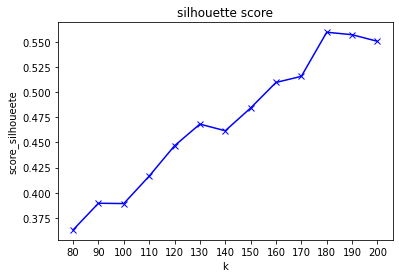

In [547]:
plt.plot(K, score_silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('score_silhoueete')
plt.xticks(K)
plt.title('silhouette score')
plt.show()

In [548]:
# Usamos como cluster 9
# Hasta ahora este ha sido la mejor configuración que he encontrado
# 50
k = 180
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, init='k-means++', batch_size=100, n_init=3)
kmeans = kmeans.fit(matrix)
labels = kmeans.labels_

In [549]:
labels

array([  1,  69,  10, ...,   3, 112,   2], dtype=int32)

In [550]:
len(labels)

19986

In [551]:
df['labels'] = labels

In [552]:
df.labels.value_counts()

11     899
8      693
87     603
129    562
18     499
      ... 
59      16
41      13
116     12
152     10
99      10
Name: labels, Length: 179, dtype: int64

In [553]:
# Guardamos las películas con sus respectivas etiquetas
df.to_csv('./data/movies_with_labels.csv', header=True, index=False)

In [554]:
def get_label(text):
    
    
    y = tfidf.transform([text])
    
    label_pred = kmeans.predict(y)
    
    return label_pred

l = get_label('animation commedy short known adventure')

In [555]:
l[0]

39

In [556]:
def get_df_films(label, film):

    return df[((df['labels'] == label) | (df['title'] == film))].copy()

films = get_df_films(l[0], 'Toy Story')

In [557]:
films.head(50)

,id,title,genre,country,epoch,duration,known,description,documents,labels
1176,tt0048280,Lady and the Tramp,"Animation, Adventure, Comedy",USA,classic,short,known,The romantic tale of a sheltered uptown Cocker...,animation adventure comedy. classic. known,39
1640,tt0055254,One Hundred and One Dalmatians,"Animation, Adventure, Comedy",USA,classic,short,known,When a litter of Dalmatian puppies are abducte...,animation adventure comedy. classic. known,39
1822,tt0057546,The Sword in the Stone,"Animation, Adventure, Comedy",USA,classic,short,known,A poor boy named Arthur learns the power of lo...,animation adventure comedy. classic. known,39
2406,tt0065421,The AristoCats,"Animation, Adventure, Comedy",USA,classic,short,known,"With the help of a smooth talking tomcat, a fa...",animation adventure comedy. classic. known,39
2522,tt0066817,Bedknobs and Broomsticks,"Animation, Adventure, Comedy",USA,classic,normal,known,"An apprentice witch, three kids and a cynical ...",animation adventure comedy. classic. known,39
2817,tt0070608,Robin Hood,"Animation, Adventure, Comedy",USA,classic,short,known,The story of the legendary outlaw is portrayed...,animation adventure comedy. classic. known,39
3213,tt0076363,The Many Adventures of Winnie the Pooh,"Animation, Adventure, Comedy",USA,classic,short,known,In this collection of animated shorts based on...,animation adventure comedy. classic. known,39
3221,tt0076538,Pete's Dragon,"Animation, Adventure, Comedy",USA,classic,long,known,An orphan boy and his magical dragon come to t...,animation adventure comedy. classic. known,39
3227,tt0076618,The Rescuers,"Animation, Adventure, Comedy",USA,classic,short,known,Two mice of the Rescue Aid Society search for ...,animation adventure comedy. classic. known,39
4399,tt0090633,An American Tail,"Animation, Adventure, Comedy",USA,classic,short,known,"While emigrating to the United States, a young...",animation adventure comedy. classic. known,39


In [558]:
films = films.reset_index()
films = films.drop_duplicates(subset=['title'], keep='last')
films.shape

(140, 11)

In [559]:
def get_recommendation(dataframe, film):
    
    indice_movies = pd.Series(dataframe.index, index=dataframe['title'])

    tfidf2 = CountVectorizer(stop_words='english')
    matrix_tfidf = tfidf.fit_transform(dataframe['documents'])

    cos_sim = linear_kernel(matrix_tfidf, matrix_tfidf)

    scores = sorted(list(enumerate(cos_sim[indice_movies[film]])), key=lambda l: l[1], reverse=True)

    movie_indices = [f[0] for f in scores[:10]]

    return dataframe['title'].iloc[movie_indices]

In [560]:
get_recommendation(films, 'Toy Story')

12    DuckTales the Movie: Treasure of the Lost Lamp
14                                           Aladdin
15                                   Kurenai no buta
16                                    The Pagemaster
17                                     A Goofy Movie
18                                         Toy Story
19                   Beavis and Butt-Head Do America
20                                         Space Jam
21                                          Hercules
22                                       Toy Story 2
Name: title, dtype: object

In [561]:
!ls Models

kmeans-films.joblib


In [562]:
dump(kmeans, './Models/kmeans-films.joblib')

['./Models/kmeans-films.joblib']